In [7]:
#!pip install netCDF4

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob
from netCDF4 import Dataset

%matplotlib inline

In [9]:
# era_AREA = area_grid_cell(lat, 0.375, 0.375)

In [8]:
nc_path   = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates/'
#nc_path  = '//home/hanna/Desktop/examples_master_thesis/'
nc_file  = glob.glob(nc_path + '*.nc')[0]
rootgrp = Dataset(nc_file, "r", format="NETCDF4")
cloud_mask = rootgrp.variables["cloudMask"][:].data
lat_array = rootgrp.variables["lat"][:].data
lon_array = rootgrp.variables["lon"][:].data
lat_array[lat_array < -99] = np.nan # updates of disk values to nan
lon_array[lon_array < -99] = np.nan # updates of disk values to nan
#d_phi   = lon_array[:, 1:] - lon_array[:, :-1]
#d_theta = lat_array[1:, :] - lat_array[:-1, :]

# Padding the axis -- we removed by taking the difference
#pad     = np.ones((3712, 1))*np.nan # adding numpy to the axis the values
#d_phi   = np.concatenate((pad, d_phi), axis = 1)/2
#d_theta = np.concatenate((pad.transpose(), d_theta), axis = 0)/2

In [9]:
rootgrp

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    creator_name: EUMETSAT
    creator_url: http://archive.eumetsat.int
    creator_email: archive@eumetsat.int
    institution: EUMETSAT
    license: CopyRight EUMETSAT 2008
    Conventions: CF-1.0
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    title: EUMETSAT-ARCHIVE-CLOUD-MASK-NetCDF
    summary: NA
    keywords: EUMETSAT, ARCHIVE, NetCDF, CLOUD MASK
    history: EUMETSAT CopyRight 2008
    comment: DRAFT VERSION
    wmo_filename: W_XX-EUMETSAT-Darmstadt,SING+LEV+SAT,MSG4+CLM_C_EUMG_20190613053000.nc
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: 0.0
    GRIB_param_Nx: 3712
    GRIB_param_Ny: 3712
    GRIB_orgReferenceTime: 20190613053000
    time_coverage_start: 20190613053000
    time_coverage_end: 20190613053000
    source: /data/products/1338648/MSG4-SEVI-MSGCLMK-0100-0100-20190613053000.000000000Z-20190613054348-1338648.nc.tmp
    dimensions(

In [10]:
def area_grid_cell(c_lat, d_lat, d_lon):
        """
        c_lat : float
            Centre point longitude, latitude in degrees

        d_lat, d_lon : float
            delta lat lon in degrees

        Returns : area in km^2

        cdo : If the grid cell area have to be computed it is scaled with the earth radius to square meters.
        """
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)


In [11]:
def compute_dDegrees(lat, lon):

    d_phi_new2    = np.nan*np.zeros(np.shape(lat))
    d_theta_new2  = np.nan*np.zeros(np.shape(lat))
    cell_areas    = np.nan*np.zeros(np.shape(lat))
    
    count_lon     = 0
    count_lat     = 0
    
    for i in range(1, len(lat)-1):
        for j in range(1, len(lat)-1):
            left_half_dist     = (lon[i, j] - lon[i, j+1])/2
            right_half_dist    = (lon[i, j-1] - lon[i, j])/2
            
            if lon[i, j] == lon[i, j+1]:
                count_lon += 1
                
            #print("left_half_dist {}, right _half_dist {}".format(left_half_dist, right_half_dist))
            dlon = (np.abs(left_half_dist) + np.abs(right_half_dist))/2
            d_phi_new2[i][j]   = dlon
            
            if lat[i-1, j] == lat[i, j]:
                count_lat += 1
                
            upper_half_dist    = (lat[i+1, j] - lat[i, j])/2
            lower_half_dist    = (lat[i, j] - lat[i-1, j])/2
            #print("upper_half_dist {}, lower_half_dist {}".format(upper_half_dist, lower_half_dist))
            dlat = (np.abs(upper_half_dist) + np.abs(lower_half_dist))/2
            d_theta_new2[i][j] = dlat
                
            cell_areas[i][j] = area_grid_cell(lat[i, j], dlat, dlon)       
            
    return d_phi_new2, d_theta_new2, cell_areas, count_lon, count_lat

In [12]:
d_phi_new2, d_theta_new2, cell_areas, count_lon, count_lat = compute_dDegrees(lat_array, lon_array)

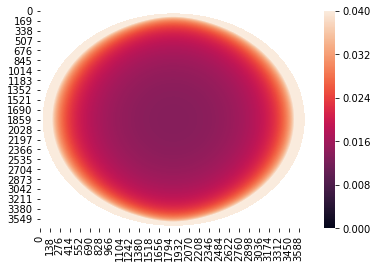

In [13]:
sns.heatmap(d_phi_new2, vmin = 0, vmax = 0.04)

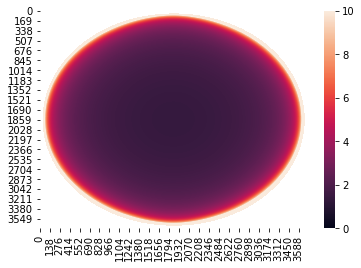

In [14]:
sns.heatmap(cell_areas, vmin = 0, vmax = 10)

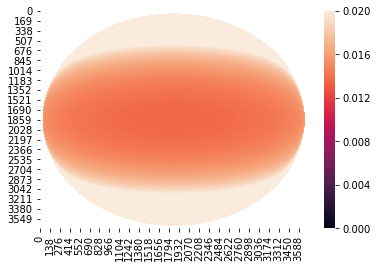

In [15]:
sns.heatmap(d_theta_new2, vmin = 0, vmax = 0.02)

In [28]:
def add(a, b):
    return np.abs(a) + np.abs(b)

def subtract(a, b):
    return np.abs(a) - np.abs(b)

In [30]:
def get_centre_centre_cells():
    pass

In [53]:
def compute_area_one_cell(lat = 60, lon = -15, c_lat = None, 
                          c_lon = None, d_theta = None, d_phi = None, cloud_mask_array = None):
    
    assert c_lon.shape == c_lat.shape == d_theta.shape == d_phi.shape == cloud_mask_array.shape, " c_lon.shape {},  c_lat.shape {},  d_theta.shape {}, d_phi.shape {} cloud_mask_array.shape {}".format(c_lon.shape,  c_lat.shape,  d_theta.shape, d_phi.shape, cloud_mask_array.shape) 
    
    era_AREA = area_grid_cell(lat, 0.375, 0.375)
    print("lat = {}, lon ={} era_AREA {}".format(era_AREA, lat, lon))

    # Make this a loop over lat_lons?
    lat_bondaries = np.array([[lon],
                              [lat]])

    BOUND =  np.array([[-0.75/2, 0.75/2],
                       [-0.75/2, 0.75/2]])

    ranges = lat_bondaries + BOUND

    #lon_range = ranges[0, :]
    #lat_range = ranges[1, :]
    #min_lon, max_lon = lon_range
    #min_lat, max_lat = lat_range

    era_up    = ranges[1, 1]
    era_down  = ranges[1, 0]
    era_left  = ranges[0, 0]
    era_right = ranges[0, 1]

    # to ensure correct sign
    cmk_left  = c_lon - np.abs(d_phi)   #- era_right
    cmk_right = c_lon + np.abs(d_phi)   #- era_left

    # TODO : Sjekk d theta og lignende.
    cmk_up    = c_lat + np.abs(d_theta) #- era_down
    cmk_down  = c_lat - np.abs(d_theta) #- era_up

    idx_left_boundary  = np.intersect1d(np.argwhere(cmk_right > era_left),  np.argwhere(cmk_left < era_left) )
    idx_right_boundary = np.intersect1d(np.argwhere(cmk_right > era_right), np.argwhere(cmk_left < era_right) )
    idx_up_boundary    = np.intersect1d(np.argwhere(cmk_up > era_up), np.argwhere(cmk_down < era_up) )
    idx_down_boundary  = np.intersect1d(np.argwhere(cmk_up > era_down), np.argwhere(cmk_down < era_down) )
    
    idx_lower_right_corner = np.intersect1d(idx_down_boundary, idx_right_boundary)
    idx_lower_left_corner  = np.intersect1d(idx_down_boundary, idx_left_boundary)
    idx_upper_left_corner  = np.intersect1d(idx_up_boundary, idx_left_boundary)
    idx_upper_right_corner = np.intersect1d(idx_up_boundary, idx_right_boundary)

    corner_idx         = np.concatenate([idx_lower_right_corner, idx_lower_left_corner,
                                         idx_upper_left_corner, idx_upper_right_corner]) # corner idx
  
    #assert len(corner_idx) == 4, "Not correct number of corners, nbr = {}.".format(len(corner_idx))
    
    # TODO add new centre corners. And calculate  
    llc_dlat = subtract(cmk_up[idx_lower_left_corner], era_down)/2
    llc_dlon = subtract(era_left, cmk_right[idx_lower_left_corner])/2
    llc_lat  = era_down + llc_dlat
    f = area_grid_cell(llc_lat, llc_dlat, llc_dlon)
    #print("area lower left area {}".format(f/era_AREA))
    
    lrc_dlat = subtract(cmk_up[idx_lower_right_corner], era_down)/2
    lrc_dlon = subtract(cmk_left[idx_lower_right_corner], era_right)/2
    lrc_lat  = era_down + lrc_dlat
    h = area_grid_cell(lrc_lat, lrc_dlat, lrc_dlon)
    #print("area lower right area {}".format(h/era_AREA))
    
    ulc_dlat = subtract(era_up, cmk_down[idx_upper_left_corner])/2
    ulc_dlon = subtract(era_left, cmk_right[idx_upper_left_corner])/2
    ulc_lat = era_up - ulc_dlat
    i = area_grid_cell(ulc_lat, ulc_dlat, ulc_dlon)
    #print("area upper left area {}".format(i/era_AREA))
    
    urc_dlat = subtract(era_up, cmk_down[idx_upper_right_corner])/2
    urc_dlon = subtract(cmk_left[idx_upper_right_corner], era_right)/2
    urc_lat  = era_up - ulc_dlat
    j = area_grid_cell(urc_lat, urc_dlat, urc_dlon)
    #print("area upper right area {}".format(j/era_AREA))
    
    #print("SUM corners {}".format((i+j+h+f)/era_AREA))

    if len(corner_idx) == 0:
        raise ValueError('No corners found, something is wrong ... ')
    
    #max_lon, min_lon = np.max(c_lon[corner_idx]), np.min(c_lon[corner_idx])
    #max_lat, min_lat = np.max(c_lat[corner_idx]), np.min(c_lat[corner_idx])

    # removes corners
    for idx in corner_idx:
        idx_down_boundary = idx_down_boundary[idx_down_boundary != idx]
        idx_up_boundary = idx_up_boundary[idx_up_boundary != idx]
        idx_left_boundary = idx_left_boundary[idx_left_boundary != idx]
        idx_right_boundary = idx_right_boundary[idx_right_boundary != idx]
        
    #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_right_corner]
    #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_left_corner]

    #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_right_corner]
    #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_left_corner]

    #idx_left_boundary = idx_left_boundary[idx_left_boundary != upper_left_corner]
    #idx_left_boundary = idx_left_boundary[idx_left_boundary != lower_left_corner]

    #idx_right_boundary = idx_right_boundary[idx_right_boundary != upper_right_corner]
    #idx_right_boundary = idx_right_boundary[idx_right_boundary != lower_right_corner]
    
    # subsection left boundary OLD
    low_bound = np.argwhere(cmk_down[idx_left_boundary] < era_up  )
    up_bound  = np.argwhere(cmk_up[idx_left_boundary]   > era_down )
    sub_section_left = np.intersect1d(low_bound, up_bound)

    # subsection right boundary
    low_bound = np.argwhere( cmk_down[idx_right_boundary] < era_up )
    up_bound  = np.argwhere( cmk_up[idx_right_boundary] > era_down)
    sub_section_right = np.intersect1d(low_bound, up_bound)

    # Subsection Down Boundary
    one = np.argwhere(cmk_left[idx_down_boundary]  > era_left)
    two = np.argwhere(cmk_right[idx_down_boundary] < era_right)
    sub_section_down = np.intersect1d(one, two)

    # subsection up boundary
    one = np.argwhere( cmk_left[idx_up_boundary]  > era_left)
    two = np.argwhere( cmk_right[idx_up_boundary] < era_right)
    sub_section_up = np.intersect1d(one, two)
    
    #plt.scatter(cmk_left[corner_idx], cmk_up[corner_idx],        marker = 'v')
    #plt.scatter(cmk_left[idx_left_boundary][sub_section_left],   cmk_up[idx_left_boundary][sub_section_left])
    #plt.scatter(cmk_left[idx_right_boundary][sub_section_right], cmk_up[idx_right_boundary][sub_section_right])
    #plt.scatter(cmk_left[idx_up_boundary][sub_section_up],       cmk_up[idx_up_boundary][sub_section_up])
    #plt.scatter(cmk_left[idx_down_boundary][sub_section_down],   cmk_up[idx_down_boundary][sub_section_down])
    #plt.show()
    
    # test that these are empty
    t1 = np.intersect1d(idx_down_boundary, idx_up_boundary)
    t2 = np.intersect1d(idx_right_boundary, idx_left_boundary)
    assert len(t1) == len(t2) == 0, "intercept up down  {}, intersect left right {}.".format(t1, t2)

    # Calculate Boundaries

    # AREA left boundary
    dlon_lf = subtract(cmk_right[idx_left_boundary][sub_section_left], era_left)/2 
    dlat_lf = d_theta[idx_left_boundary][sub_section_left]
    lat_lf  = c_lat[idx_left_boundary][sub_section_left]
    #lon_lf  = c_lon[idx_left_boundary][sub_section_left]

    a = np.sum(area_grid_cell(lat_lf, dlat_lf, np.abs(dlon_lf)))

    fraction_left = (cloud_mask_array[idx_left_boundary][sub_section_left]*area_grid_cell(lat_lf,
                                                                                          dlat_lf,
                                                                                          dlon_lf)/era_AREA).sum()
    # AREA right boundary
    dlon_rb = subtract(era_right, cmk_left[idx_right_boundary][sub_section_right])/2
    dlat_rb = d_theta[idx_right_boundary][sub_section_right]
    lat_rb  = c_lat[idx_right_boundary][sub_section_right]
    #lon_rb = c_lon[idx_right_boundary][sub_section_right]

    b = np.sum(area_grid_cell(lat_rb, dlat_rb, np.abs(dlon_rb)))

    fraction_right = (cloud_mask_array[idx_right_boundary][sub_section_right]*area_grid_cell(lat_rb,
                                                                                             dlat_rb,
                                                                                             dlon_rb)/era_AREA).sum()

    # AREA down boundary
    dlat_down = subtract(era_down, cmk_up[idx_down_boundary][sub_section_down])/2
    lat_down = era_down + dlat_down
    dlon_down = d_phi[idx_down_boundary][sub_section_down]
    #lon_down =  c_lon[idx_down_boundary][sub_section_down]

    c = np.sum(area_grid_cell(lat_down, dlat_down, dlon_down))

    fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
                                                                                          dlat_down,
                                                                                          dlon_down)/era_AREA).sum()
    # AREA up
    dlat_up = subtract(era_up, cmk_down[idx_up_boundary][sub_section_up])/2
    lat_up = era_up - dlat_up
    #lon_up = c_lon[idx_up_boundary][sub_section_up]
    dlon_up = d_phi[idx_up_boundary][sub_section_up]

    d = np.sum(area_grid_cell(lat_up, dlat_up, np.abs(dlon_up)))

    fraction_up = (cloud_mask_array[idx_up_boundary][sub_section_up]*area_grid_cell(lat_up,
                                                                 dlat_up,
                                                                 dlon_up)/era_AREA).sum()
    # Index centres. Can safly assume centre cells are correct.
    idx_centre_one = np.intersect1d(np.argwhere(cmk_left  > era_left),
                                    np.argwhere(cmk_right < era_right))


    idx_centre_two = np.intersect1d(np.argwhere(cmk_up   < era_up),
                                    np.argwhere(cmk_down >  era_down))

    idx_centre_cells = np.intersect1d( idx_centre_one, idx_centre_two )
    lat_centre_cells = c_lat[idx_centre_cells]
    dlat_centre      = d_theta[idx_centre_cells]
    dlon_centre      = d_phi[idx_centre_cells]
    
    #plt.scatter(cmk_left[idx_centre_cells], cmk_up[idx_centre_cells])
    #plt.scatter([lon+.375, lon-.375, lon+.375, lon-.375,], [lat+.375, lat+.375, lat-.375,lat-.375])
    #plt.show()
    
    fraction_centre  = (cloud_mask_array[idx_centre_cells]*area_grid_cell(lat_centre_cells,
                                                                 dlat_centre,
                                                                 dlon_centre)/era_AREA).sum()
    #print("era_AREA {}".format(era_AREA))
    #print("Sum up {}".format(area_grid_cell(lat_up, dlat_up, dlon_up).sum()/era_AREA))
    #print("Sum down {}".format(area_grid_cell(lat_down, dlat_down, dlon_down).sum()/era_AREA))
    #print("Sum centre {}".format(area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() /era_AREA))
    #print("Sum left {}".format(area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum()/era_AREA))
    #print("Sum right {}".format(area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum()/era_AREA))
    
    Test_weight = (area_grid_cell(lat_up, dlat_up, dlon_up).sum() +
                   area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() +
                   area_grid_cell(lat_down, dlat_down, dlon_down).sum() +
                   area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum() +
                   area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum() ) /era_AREA + (i+j+h+f)/era_AREA
    
    print("SUM weight {}".format(Test_weight[0]))
    return Test_weight[0]


In [60]:
areas = []
lats = np.arange(30, 56, 0.75)
lons = np.arange(-15, 30, 0.75)
for la in lats:
    for lo in lons:
        area = compute_area_one_cell(lat = la, lon = lo, c_lat = lat_array.reshape(-1), 
                              c_lon = lon_array.reshape(-1), d_theta = d_theta_new2.reshape(-1), 
                              d_phi = d_phi_new2.reshape(-1), cloud_mask_array = cloud_mask.reshape(-1)  )
        areas.append(area)

lat = 945.393034363, lon =30.0 era_AREA -15.0


/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value enc

SUM weight 1.00482041571
lat = 945.393034363, lon =30.0 era_AREA -14.25
SUM weight 1.00433638717
lat = 945.393034363, lon =30.0 era_AREA -13.5
SUM weight 1.00390615548
lat = 945.393034363, lon =30.0 era_AREA -12.75
SUM weight 1.00345725511
lat = 945.393034363, lon =30.0 era_AREA -12.0
SUM weight 1.00309060898
lat = 945.393034363, lon =30.0 era_AREA -11.25
SUM weight 1.0026928992
lat = 945.393034363, lon =30.0 era_AREA -10.5
SUM weight 1.00236483151
lat = 945.393034363, lon =30.0 era_AREA -9.75
SUM weight 1.0020237741
lat = 945.393034363, lon =30.0 era_AREA -9.0
SUM weight 1.00172504437
lat = 945.393034363, lon =30.0 era_AREA -8.25
SUM weight 1.00146443001
lat = 945.393034363, lon =30.0 era_AREA -7.5
SUM weight 1.00119677016
lat = 945.393034363, lon =30.0 era_AREA -6.75
SUM weight 1.00096810033
lat = 945.393034363, lon =30.0 era_AREA -6.0
SUM weight 1.00077661918
lat = 945.393034363, lon =30.0 era_AREA -5.25
SUM weight 1.0005981198
lat = 945.393034363, lon =30.0 era_AREA -4.5
SUM weight

SUM weight 1.01680503386
lat = 938.167438934, lon =30.75 era_AREA 27.75
SUM weight 1.01780151179
lat = 938.167438934, lon =30.75 era_AREA 28.5
SUM weight 1.0188406459
lat = 938.167438934, lon =30.75 era_AREA 29.25
SUM weight 1.01988213778
lat = 930.781093345, lon =31.5 era_AREA -15.0
SUM weight 1.00541954167
lat = 930.781093345, lon =31.5 era_AREA -14.25
SUM weight 1.0047657561
lat = 930.781093345, lon =31.5 era_AREA -13.5
SUM weight 1.00434680451
lat = 930.781093345, lon =31.5 era_AREA -12.75
SUM weight 1.00383120917
lat = 930.781093345, lon =31.5 era_AREA -12.0
SUM weight 1.0034166038
lat = 930.781093345, lon =31.5 era_AREA -11.25
SUM weight 1.00298166459
lat = 930.781093345, lon =31.5 era_AREA -10.5
SUM weight 1.00263728339
lat = 930.781093345, lon =31.5 era_AREA -9.75
SUM weight 1.00220415992
lat = 930.781093345, lon =31.5 era_AREA -9.0
SUM weight 1.00194787668
lat = 930.781093345, lon =31.5 era_AREA -8.25
SUM weight 1.00160743746
lat = 930.781093345, lon =31.5 era_AREA -7.5
SUM we

SUM weight 1.01458824451
lat = 923.235263206, lon =32.25 era_AREA 24.75
SUM weight 1.01552851038
lat = 923.235263206, lon =32.25 era_AREA 25.5
SUM weight 1.01651510473
lat = 923.235263206, lon =32.25 era_AREA 26.25
SUM weight 1.01753452255
lat = 923.235263206, lon =32.25 era_AREA 27.0
SUM weight 1.01860672294
lat = 923.235263206, lon =32.25 era_AREA 27.75
SUM weight 1.01967893347
lat = 923.235263206, lon =32.25 era_AREA 28.5
SUM weight 1.02081725247
lat = 923.235263206, lon =32.25 era_AREA 29.25
SUM weight 1.02196316043
lat = 915.531241458, lon =33.0 era_AREA -15.0
SUM weight 1.00588375696
lat = 915.531241458, lon =33.0 era_AREA -14.25
SUM weight 1.00531773851
lat = 915.531241458, lon =33.0 era_AREA -13.5
SUM weight 1.00475358841
lat = 915.531241458, lon =33.0 era_AREA -12.75
SUM weight 1.00423167877
lat = 915.531241458, lon =33.0 era_AREA -12.0
SUM weight 1.00375725175
lat = 915.531241458, lon =33.0 era_AREA -11.25
SUM weight 1.00331076957
lat = 915.531241458, lon =33.0 era_AREA -10.5

SUM weight 1.01229487238
lat = 907.670348145, lon =33.75 era_AREA 21.75
SUM weight 1.01314904224
lat = 907.670348145, lon =33.75 era_AREA 22.5
SUM weight 1.01405474138
lat = 907.670348145, lon =33.75 era_AREA 23.25
SUM weight 1.01503271504
lat = 907.670348145, lon =33.75 era_AREA 24.0
SUM weight 1.01605946742
lat = 907.670348145, lon =33.75 era_AREA 24.75
SUM weight 1.01711239823
lat = 907.670348145, lon =33.75 era_AREA 25.5
SUM weight 1.01823239383
lat = 907.670348145, lon =33.75 era_AREA 26.25
SUM weight 1.01935767242
lat = 907.670348145, lon =33.75 era_AREA 27.0
SUM weight 1.0205232472
lat = 907.670348145, lon =33.75 era_AREA 27.75
SUM weight 1.02173518863
lat = 907.670348145, lon =33.75 era_AREA 28.5
SUM weight 1.02301107668
lat = 907.670348145, lon =33.75 era_AREA 29.25
SUM weight 1.02421598304
lat = 899.653930191, lon =34.5 era_AREA -15.0
SUM weight 1.0063853566
lat = 899.653930191, lon =34.5 era_AREA -14.25
SUM weight 1.00591497861
lat = 899.653930191, lon =34.5 era_AREA -13.5
S

SUM weight 1.00984261283
lat = 891.483361167, lon =35.25 era_AREA 18.75
SUM weight 1.01068825603
lat = 891.483361167, lon =35.25 era_AREA 19.5
SUM weight 1.01146689422
lat = 891.483361167, lon =35.25 era_AREA 20.25
SUM weight 1.01248223905
lat = 891.483361167, lon =35.25 era_AREA 21.0
SUM weight 1.013442285
lat = 891.483361167, lon =35.25 era_AREA 21.75
SUM weight 1.01445056986
lat = 891.483361167, lon =35.25 era_AREA 22.5
SUM weight 1.01546885296
lat = 891.483361167, lon =35.25 era_AREA 23.25
SUM weight 1.01654923476
lat = 891.483361167, lon =35.25 era_AREA 24.0
SUM weight 1.01766880021
lat = 891.483361167, lon =35.25 era_AREA 24.75
SUM weight 1.01881817331
lat = 891.483361167, lon =35.25 era_AREA 25.5
SUM weight 1.02001651582
lat = 891.483361167, lon =35.25 era_AREA 26.25
SUM weight 1.02127298215
lat = 891.483361167, lon =35.25 era_AREA 27.0
SUM weight 1.02251756914
lat = 891.483361167, lon =35.25 era_AREA 27.75
SUM weight 1.0238651641
lat = 891.483361167, lon =35.25 era_AREA 28.5
SU

SUM weight 1.00753168669
lat = 874.685396023, lon =36.75 era_AREA 15.75
SUM weight 1.00811867879
lat = 874.685396023, lon =36.75 era_AREA 16.5
SUM weight 1.00899189047
lat = 874.685396023, lon =36.75 era_AREA 17.25
SUM weight 1.00997344058
lat = 874.685396023, lon =36.75 era_AREA 18.0
SUM weight 1.01071017864
lat = 874.685396023, lon =36.75 era_AREA 18.75
SUM weight 1.01160392386
lat = 874.685396023, lon =36.75 era_AREA 19.5
SUM weight 1.01260751908
lat = 874.685396023, lon =36.75 era_AREA 20.25
SUM weight 1.01373571967
lat = 874.685396023, lon =36.75 era_AREA 21.0
SUM weight 1.01476470028
lat = 874.685396023, lon =36.75 era_AREA 21.75
SUM weight 1.01586324274
lat = 874.685396023, lon =36.75 era_AREA 22.5
SUM weight 1.01691326435
lat = 874.685396023, lon =36.75 era_AREA 23.25
SUM weight 1.01809853819
lat = 874.685396023, lon =36.75 era_AREA 24.0
SUM weight 1.01934144596
lat = 874.685396023, lon =36.75 era_AREA 24.75
SUM weight 1.02063004543
lat = 874.685396023, lon =36.75 era_AREA 25.5

SUM weight 1.00584377903
lat = 857.2879652, lon =38.25 era_AREA 13.5
SUM weight 1.00657046285
lat = 857.2879652, lon =38.25 era_AREA 14.25
SUM weight 1.00733322586
lat = 857.2879652, lon =38.25 era_AREA 15.0
SUM weight 1.00810356407
lat = 857.2879652, lon =38.25 era_AREA 15.75
SUM weight 1.00896008554
lat = 857.2879652, lon =38.25 era_AREA 16.5
SUM weight 1.0098508625
lat = 857.2879652, lon =38.25 era_AREA 17.25
SUM weight 1.01076755532
lat = 857.2879652, lon =38.25 era_AREA 18.0
SUM weight 1.01173219324
lat = 857.2879652, lon =38.25 era_AREA 18.75
SUM weight 1.01276299186
lat = 857.2879652, lon =38.25 era_AREA 19.5
SUM weight 1.01383051961
lat = 857.2879652, lon =38.25 era_AREA 20.25
SUM weight 1.0149288644
lat = 857.2879652, lon =38.25 era_AREA 21.0
SUM weight 1.01606402041
lat = 857.2879652, lon =38.25 era_AREA 21.75
SUM weight 1.01726772461
lat = 857.2879652, lon =38.25 era_AREA 22.5
SUM weight 1.01850701873
lat = 857.2879652, lon =38.25 era_AREA 23.25
SUM weight 1.01981805118
lat 

SUM weight 1.00438322429
lat = 839.302992029, lon =39.75 era_AREA 11.25
SUM weight 1.00487493543
lat = 839.302992029, lon =39.75 era_AREA 12.0
SUM weight 1.00573802605
lat = 839.302992029, lon =39.75 era_AREA 12.75
SUM weight 1.00630613892
lat = 839.302992029, lon =39.75 era_AREA 13.5
SUM weight 1.00719064263
lat = 839.302992029, lon =39.75 era_AREA 14.25
SUM weight 1.00800214519
lat = 839.302992029, lon =39.75 era_AREA 15.0
SUM weight 1.00875078205
lat = 839.302992029, lon =39.75 era_AREA 15.75
SUM weight 1.00987155019
lat = 839.302992029, lon =39.75 era_AREA 16.5
SUM weight 1.01072039462
lat = 839.302992029, lon =39.75 era_AREA 17.25
SUM weight 1.01160673064
lat = 839.302992029, lon =39.75 era_AREA 18.0
SUM weight 1.0128671467
lat = 839.302992029, lon =39.75 era_AREA 18.75
SUM weight 1.01399052744
lat = 839.302992029, lon =39.75 era_AREA 19.5
SUM weight 1.01511325496
lat = 839.302992029, lon =39.75 era_AREA 20.25
SUM weight 1.01617451282
lat = 839.302992029, lon =39.75 era_AREA 21.0


SUM weight 1.00241554276
lat = 820.742802511, lon =41.25 era_AREA 8.25
SUM weight 1.00292692583
lat = 820.742802511, lon =41.25 era_AREA 9.0
SUM weight 1.00340094936
lat = 820.742802511, lon =41.25 era_AREA 9.75
SUM weight 1.00407821806
lat = 820.742802511, lon =41.25 era_AREA 10.5
SUM weight 1.00464206469
lat = 820.742802511, lon =41.25 era_AREA 11.25
SUM weight 1.00544448391
lat = 820.742802511, lon =41.25 era_AREA 12.0
SUM weight 1.00327919875
lat = 820.742802511, lon =41.25 era_AREA 12.75
SUM weight 1.00692647375
lat = 820.742802511, lon =41.25 era_AREA 13.5
SUM weight 1.00771198687
lat = 820.742802511, lon =41.25 era_AREA 14.25
SUM weight 1.00877214488
lat = 820.742802511, lon =41.25 era_AREA 15.0
SUM weight 1.00956574655
lat = 820.742802511, lon =41.25 era_AREA 15.75
SUM weight 1.01056534028
lat = 820.742802511, lon =41.25 era_AREA 16.5
SUM weight 1.01179797297
lat = 820.742802511, lon =41.25 era_AREA 17.25
SUM weight 1.01271079963
lat = 820.742802511, lon =41.25 era_AREA 18.0
SU

SUM weight 1.00131787183
lat = 801.620116873, lon =42.75 era_AREA 6.0
SUM weight 1.00164522848
lat = 801.620116873, lon =42.75 era_AREA 6.75
SUM weight 1.0020863888
lat = 801.620116873, lon =42.75 era_AREA 7.5
SUM weight 1.00262400624
lat = 801.620116873, lon =42.75 era_AREA 8.25
SUM weight 1.00315104933
lat = 801.620116873, lon =42.75 era_AREA 9.0
SUM weight 1.00370388136
lat = 801.620116873, lon =42.75 era_AREA 9.75
SUM weight 1.00446590425
lat = 801.620116873, lon =42.75 era_AREA 10.5
SUM weight 1.00503856417
lat = 801.620116873, lon =42.75 era_AREA 11.25
SUM weight 1.00593162086
lat = 801.620116873, lon =42.75 era_AREA 12.0
SUM weight 1.00658797337
lat = 801.620116873, lon =42.75 era_AREA 12.75
SUM weight 1.00760858121
lat = 801.620116873, lon =42.75 era_AREA 13.5
SUM weight 1.00834977356
lat = 801.620116873, lon =42.75 era_AREA 14.25
SUM weight 1.00948505782
lat = 801.620116873, lon =42.75 era_AREA 15.0
SUM weight 1.01040321831
lat = 801.620116873, lon =42.75 era_AREA 15.75
SUM we

SUM weight 1.0002695779
lat = 781.948040849, lon =44.25 era_AREA 3.0
SUM weight 1.00046542518
lat = 781.948040849, lon =44.25 era_AREA 3.75
SUM weight 1.00069945193
lat = 781.948040849, lon =44.25 era_AREA 4.5
SUM weight 1.00101052229
lat = 781.948040849, lon =44.25 era_AREA 5.25
SUM weight 1.00139855109
lat = 781.948040849, lon =44.25 era_AREA 6.0
SUM weight 1.00184902099
lat = 781.948040849, lon =44.25 era_AREA 6.75
SUM weight 1.00227043338
lat = 781.948040849, lon =44.25 era_AREA 7.5
SUM weight 1.00276493941
lat = 781.948040849, lon =44.25 era_AREA 8.25
SUM weight 1.00349247888
lat = 781.948040849, lon =44.25 era_AREA 9.0
SUM weight 1.00402736543
lat = 781.948040849, lon =44.25 era_AREA 9.75
SUM weight 1.00473630415
lat = 781.948040849, lon =44.25 era_AREA 10.5
SUM weight 1.00561137722
lat = 781.948040849, lon =44.25 era_AREA 11.25
SUM weight 1.00624537781
lat = 781.948040849, lon =44.25 era_AREA 12.0
SUM weight 1.00733204371
lat = 781.948040849, lon =44.25 era_AREA 12.75
SUM weight

SUM weight 1.00004880268
lat = 761.740056697, lon =45.75 era_AREA 0.0
SUM weight 1.00001552434
lat = 761.740056697, lon =45.75 era_AREA 0.75
SUM weight 1.00004882487
lat = 761.740056697, lon =45.75 era_AREA 1.5
SUM weight 1.00013882618
lat = 761.740056697, lon =45.75 era_AREA 2.25
SUM weight 1.00030098527
lat = 761.740056697, lon =45.75 era_AREA 3.0
SUM weight 1.00052049188
lat = 761.740056697, lon =45.75 era_AREA 3.75
SUM weight 1.00077887506
lat = 761.740056697, lon =45.75 era_AREA 4.5
SUM weight 1.00109663987
lat = 761.740056697, lon =45.75 era_AREA 5.25
SUM weight 1.00150324824
lat = 761.740056697, lon =45.75 era_AREA 6.0
SUM weight 1.00197050648
lat = 761.740056697, lon =45.75 era_AREA 6.75
SUM weight 1.00249235574
lat = 761.740056697, lon =45.75 era_AREA 7.5
SUM weight 1.00302671753
lat = 761.740056697, lon =45.75 era_AREA 8.25
SUM weight 1.00371774951
lat = 761.740056697, lon =45.75 era_AREA 9.0
SUM weight 1.00436995929
lat = 761.740056697, lon =45.75 era_AREA 9.75
SUM weight 1.

SUM weight 1.00082422838
lat = 741.010013959, lon =47.25 era_AREA -3.0
SUM weight 1.00052515473
lat = 741.010013959, lon =47.25 era_AREA -2.25
SUM weight 1.00031484419
lat = 741.010013959, lon =47.25 era_AREA -1.5
SUM weight 1.00014314464
lat = 741.010013959, lon =47.25 era_AREA -0.75
SUM weight 1.00003996573
lat = 741.010013959, lon =47.25 era_AREA 0.0
SUM weight 1.00000460782
lat = 741.010013959, lon =47.25 era_AREA 0.75
SUM weight 1.00003997369
lat = 741.010013959, lon =47.25 era_AREA 1.5
SUM weight 1.00014316835
lat = 741.010013959, lon =47.25 era_AREA 2.25
SUM weight 1.00031484646
lat = 741.010013959, lon =47.25 era_AREA 3.0
SUM weight 1.00052462457
lat = 741.010013959, lon =47.25 era_AREA 3.75
SUM weight 1.00082439776
lat = 741.010013959, lon =47.25 era_AREA 4.5
SUM weight 1.00118631837
lat = 741.010013959, lon =47.25 era_AREA 5.25
SUM weight 1.00162429066
lat = 741.010013959, lon =47.25 era_AREA 6.0
SUM weight 1.00219495377
lat = 741.010013959, lon =47.25 era_AREA 6.75
SUM weigh

SUM weight 1.00295749102
lat = 719.772119973, lon =48.75 era_AREA -6.0
SUM weight 1.00225238076
lat = 719.772119973, lon =48.75 era_AREA -5.25
SUM weight 1.00171167106
lat = 719.772119973, lon =48.75 era_AREA -4.5
SUM weight 1.0013313273
lat = 719.772119973, lon =48.75 era_AREA -3.75
SUM weight 1.00092641635
lat = 719.772119973, lon =48.75 era_AREA -3.0
SUM weight 1.00058907037
lat = 719.772119973, lon =48.75 era_AREA -2.25
SUM weight 1.00033378067
lat = 719.772119973, lon =48.75 era_AREA -1.5
SUM weight 1.00020223548
lat = 719.772119973, lon =48.75 era_AREA -0.75
SUM weight 1.00009167497
lat = 719.772119973, lon =48.75 era_AREA 0.0
SUM weight 1.00005987627
lat = 719.772119973, lon =48.75 era_AREA 0.75
SUM weight 1.00009172675
lat = 719.772119973, lon =48.75 era_AREA 1.5
SUM weight 1.00020232942
lat = 719.772119973, lon =48.75 era_AREA 2.25
SUM weight 1.0003338998
lat = 719.772119973, lon =48.75 era_AREA 3.0
SUM weight 1.0005891892
lat = 719.772119973, lon =48.75 era_AREA 3.75
SUM weig

SUM weight 1.00657626993
lat = 698.040930129, lon =50.25 era_AREA -9.0
SUM weight 1.00559539868
lat = 698.040930129, lon =50.25 era_AREA -8.25
SUM weight 1.00463469526
lat = 698.040930129, lon =50.25 era_AREA -7.5
SUM weight 1.00390196459
lat = 698.040930129, lon =50.25 era_AREA -6.75
SUM weight 1.00314537077
lat = 698.040930129, lon =50.25 era_AREA -6.0
SUM weight 1.00245572262
lat = 698.040930129, lon =50.25 era_AREA -5.25
SUM weight 1.00192634784
lat = 698.040930129, lon =50.25 era_AREA -4.5
SUM weight 1.00142439174
lat = 698.040930129, lon =50.25 era_AREA -3.75
SUM weight 1.00098501345
lat = 698.040930129, lon =50.25 era_AREA -3.0
SUM weight 1.0006326212
lat = 698.040930129, lon =50.25 era_AREA -2.25
SUM weight 1.00035431277
lat = 698.040930129, lon =50.25 era_AREA -1.5
SUM weight 1.0001636559
lat = 698.040930129, lon =50.25 era_AREA -0.75
SUM weight 1.00004494384
lat = 698.040930129, lon =50.25 era_AREA 0.0
SUM weight 1.00000575264
lat = 698.040930129, lon =50.25 era_AREA 0.75
SUM

SUM weight 1.01222369954
lat = 675.831337899, lon =51.75 era_AREA -12.0
SUM weight 1.01061492729
lat = 675.831337899, lon =51.75 era_AREA -11.25
SUM weight 1.00957047172
lat = 675.831337899, lon =51.75 era_AREA -10.5
SUM weight 1.00804793712
lat = 675.831337899, lon =51.75 era_AREA -9.75
SUM weight 1.00728000229
lat = 675.831337899, lon =51.75 era_AREA -9.0
SUM weight 1.0059309293
lat = 675.831337899, lon =51.75 era_AREA -8.25
SUM weight 1.00495440943
lat = 675.831337899, lon =51.75 era_AREA -7.5
SUM weight 1.00436286107
lat = 675.831337899, lon =51.75 era_AREA -6.75
SUM weight 1.0033685742
lat = 675.831337899, lon =51.75 era_AREA -6.0
SUM weight 1.00263915952
lat = 675.831337899, lon =51.75 era_AREA -5.25
SUM weight 1.00200965143
lat = 675.831337899, lon =51.75 era_AREA -4.5
SUM weight 1.00158577071
lat = 675.831337899, lon =51.75 era_AREA -3.75
SUM weight 1.00111270988
lat = 675.831337899, lon =51.75 era_AREA -3.0
SUM weight 1.00071749148
lat = 675.831337899, lon =51.75 era_AREA -2.2

SUM weight 1.07015917329
lat = 653.158564629, lon =53.25 era_AREA -15.0
SUM weight 1.01875272359
lat = 653.158564629, lon =53.25 era_AREA -14.25
SUM weight 1.01604189981
lat = 653.158564629, lon =53.25 era_AREA -13.5
SUM weight 1.01507579616
lat = 653.158564629, lon =53.25 era_AREA -12.75
SUM weight 1.01283112371
lat = 653.158564629, lon =53.25 era_AREA -12.0
SUM weight 1.01110584401
lat = 653.158564629, lon =53.25 era_AREA -11.25
SUM weight 1.00549165415
lat = 653.158564629, lon =53.25 era_AREA -10.5
SUM weight 1.00915690831
lat = 653.158564629, lon =53.25 era_AREA -9.75
SUM weight 1.00757167042
lat = 653.158564629, lon =53.25 era_AREA -9.0
SUM weight 1.00644842305
lat = 653.158564629, lon =53.25 era_AREA -8.25
SUM weight 1.00565982363
lat = 653.158564629, lon =53.25 era_AREA -7.5
SUM weight 1.00447593702
lat = 653.158564629, lon =53.25 era_AREA -6.75
SUM weight 1.00355108016
lat = 653.158564629, lon =53.25 era_AREA -6.0
SUM weight 1.00299879312
lat = 653.158564629, lon =53.25 era_ARE

SUM weight 1.06066068032
lat = 641.653328864, lon =54.0 era_AREA 27.0
SUM weight 1.06429754855
lat = 641.653328864, lon =54.0 era_AREA 27.75
SUM weight 1.06817669052
lat = 641.653328864, lon =54.0 era_AREA 28.5
SUM weight 1.07211071489
lat = 641.653328864, lon =54.0 era_AREA 29.25
SUM weight 1.07621392792
lat = 630.038149104, lon =54.75 era_AREA -15.0
SUM weight 1.01982495725
lat = 630.038149104, lon =54.75 era_AREA -14.25
SUM weight 1.01779231683
lat = 630.038149104, lon =54.75 era_AREA -13.5
SUM weight 1.01601500984
lat = 630.038149104, lon =54.75 era_AREA -12.75
SUM weight 1.01420620373
lat = 630.038149104, lon =54.75 era_AREA -12.0
SUM weight 1.0126583455
lat = 630.038149104, lon =54.75 era_AREA -11.25
SUM weight 1.01099418714
lat = 630.038149104, lon =54.75 era_AREA -10.5
SUM weight 1.00967168616
lat = 630.038149104, lon =54.75 era_AREA -9.75
SUM weight 1.00822966772
lat = 630.038149104, lon =54.75 era_AREA -9.0
SUM weight 1.00709774023
lat = 630.038149104, lon =54.75 era_AREA -8.

SUM weight 1.05063634331
lat = 618.315015551, lon =55.5 era_AREA 24.0
SUM weight 1.054125435
lat = 618.315015551, lon =55.5 era_AREA 24.75
SUM weight 1.05783056402
lat = 618.315015551, lon =55.5 era_AREA 25.5
SUM weight 1.06162346398
lat = 618.315015551, lon =55.5 era_AREA 26.25
SUM weight 1.06563058476
lat = 618.315015551, lon =55.5 era_AREA 27.0
SUM weight 1.07000743686
lat = 618.315015551, lon =55.5 era_AREA 27.75
SUM weight 1.07424228462
lat = 618.315015551, lon =55.5 era_AREA 28.5
SUM weight 1.07853578605
lat = 618.315015551, lon =55.5 era_AREA 29.25
SUM weight 1.08306110229


In [61]:
#areas

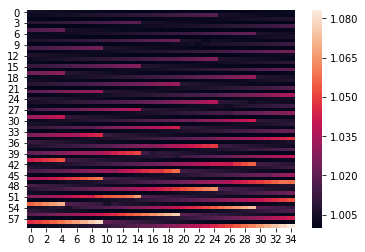

In [64]:
# reshape and make heatmap of aeras.
import seaborn as sns

ax = sns.heatmap((np.array(areas)).reshape(len(lons), len(lats)))
#ax.set_xticklabels(lons)
#ax.set_yticklabels(lats)

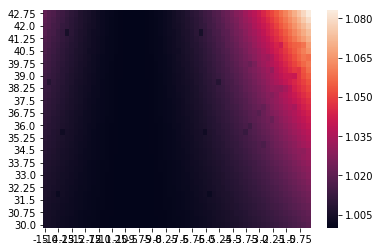

In [69]:
ax = sns.heatmap((np.array(areas)).reshape(len(lats), len(lons)))
ax.invert_yaxis()
#ax.set_yticklabels(lats);
#ax.set_xticklabels(lons);

In [45]:
plt.scatter(c_lon[idx_left_boundary],  c_lat[idx_left_boundary])
plt.scatter(c_lon[idx_right_boundary], c_lat[idx_right_boundary])

NameError: name 'c_lon' is not defined

In [ ]:
plt.scatter(c_lon[idx_down_boundary], c_lat[idx_down_boundary])

In [ ]:
# subsection left boundary OLD
low_bound = np.argwhere( cmk_up[idx_left_boundary] > min_lat  )
up_bound  = np.argwhere( cmk_down[idx_left_boundary] < max_lat  )
sub_section_left = np.intersect1d(low_bound, up_bound)

In [ ]:
sub_section_left

In [ ]:
#  subsection right boundary
low_bound = np.argwhere( cmk_up[idx_right_boundary] > min_lat )
up_bound  = np.argwhere( cmk_down[idx_right_boundary] < max_lat)
sub_section_right = np.intersect1d(low_bound, up_bound)

In [ ]:
sub_section_right

In [ ]:
# subsection left boundary OLD
low_bound = np.argwhere( cmk_right[idx_up_boundary] > min_lon )
up_bound  = np.argwhere( cmk_left[idx_up_boundary] < max_lon  )
sub_section_up = np.intersect1d(low_bound, up_bound)


In [ ]:
sub_section_up

In [ ]:
# subsection left boundary OLD
low_bound = np.argwhere( cmk_right[idx_down_boundary] > min_lon )
up_bound  = np.argwhere( cmk_left[idx_down_boundary] < max_lon  )
sub_section_down = np.intersect1d(low_bound, up_bound)

In [ ]:
up_bound.flatten()

In [ ]:
low_bound.flatten()

In [ ]:
idx_up_boundary

In [ ]:
sub_section_left

In [ ]:
min_lon, max_lon, min_lat, max_lat

In [ ]:
sub_section_down, sub_section_up

In [ ]:
(c_lon[idx_down_boundary] > min_lon).sum()

In [ ]:
( c_lon[idx_down_boundary] < max_lon).sum()

In [ ]:
max_lon

In [ ]:
cmk_left[idx_down_boundary][one].flatten() < -14.

In [ ]:
# Subsection Down Boundary
one = np.argwhere( cmk_right[idx_down_boundary] > min_lon )
two = np.argwhere( cmk_left[idx_down_boundary][one]  < max_lon )

sub_section_down = np.intersect1d(one, two)


In [ ]:
two

In [ ]:
cmk_right[idx_down_boundary][one]

In [ ]:
cmk_left[idx_down_boundary]

In [ ]:
one.flatten()

In [ ]:
two.flatten()

In [ ]:
cmk_left[idx_down_boundary] < max_lon)

In [ ]:
cmk_right[idx_down_boundary][cmk_right[idx_down_boundary] > min_lon] < ma

In [ ]:
sub_section_down

In [ ]:
plt.scatter(c_lon[sub_section_down][sub_section_down], c_lat[sub_section_down][sub_section_down] ) 

In [ ]:

# subsection up boundary
one = np.argwhere( c_lon[idx_up_boundary] > min_lon)
two = np.argwhere( c_lon[idx_up_boundary] < max_lon)
sub_section_up = np.intersect1d(one, two)

In [ ]:
c_lon[idx_left_boundary][sub_section_left], c_lat[idx_left_boundary][sub_section_left]

In [ ]:
c_lon[idx_up_boundary]#[sub_section_up]


In [ ]:
plt.scatter(c_lon[idx_left_boundary][sub_section_left],    c_lat[idx_left_boundary][sub_section_left], label = 'left')
plt.scatter(c_lon[idx_right_boundary][sub_section_right],  c_lat[idx_right_boundary][sub_section_right], label = 'right')
plt.scatter(c_lon[idx_up_boundary][sub_section_up],        c_lat[idx_up_boundary][sub_section_up], label = 'up')
plt.scatter(c_lon[idx_down_boundary][sub_section_down],    c_lat[idx_down_boundary][sub_section_down], label = 'down')
plt.legend()
#plt.scatter([-15.375, 14.625, -15.375, 14.625], [30.375, 30.375, 29.625, 29.625])

In [ ]:
c_lat[idx_left_boundary], c_lon[idx_right_boundary]

In [ ]:
clm_ax = sns.heatmap(cloud_mask)
clm_ax.invert_yaxis()

# index 0,0 is at the lower left corner 

In [ ]:
clm_ax = sns.heatmap(np.flipud(cloud_mask))

In [ ]:
ax = sns.heatmap(lat_array)
ax.set_xlabel('longitude i')
ax.set_ylabel('latitude j')


In [ ]:
ax2 = sns.heatmap(lon_array) # longitude is incleasing with index but latitude is deacreasing.

In [ ]:
compute_area_one_cell(lat = 30, lon = -15, c_lat = lat_array.reshape(-1), 
                      c_lon = lon_array.reshape(-1), d_theta = d_theta.reshape(-1), 
                      d_phi = d_phi.reshape(-1), cloud_mask_array = cloud_mask.reshape(-1))

In [ ]:
area_grid_cell(lat_up, dlat_up, dlon_up).sum()

In [ ]:
area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() +
                   area_grid_cell(lat_down, dlat_down, dlon_down).sum() +
                   area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum() +
                  area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum() ) /era_AREA

In [ ]:
lat_array

In [ ]:
sns.heatmap(d_phi)

In [ ]:
sns.heatmap(d_theta)

In [ ]:
coord_info = pd.read_csv('~/Desktop/lat_lon_dlat_dlon.csv')
c_lat = coord_info.lat.values
c_lon = coord_info.lon.values
d_phi_new = coord_info.dlon.values
d_theta_new = coord_info.dlat.values

In [ ]:
d_theta_new.shape

In [ ]:
np.sqrt(10375000)

In [ ]:
sns.heatmap(d_phi.reshape((3712,3712)) )

In [ ]:
sns.heatmap(d_theta.reshape((3712,3712)) )

In [ ]:
#plt.scatter(c_lat.)

In [ ]:
#c_lon[c_lon < -99] = np.nan
#c_lat[c_lat < -99] = np.nan

In [ ]:
#sns.kdeplot(c_lon, c_lat)

In [ ]:
#sns.heatmap(d_phi.reshape((3712, 3712)))

In [ ]:
#sns.heatmap(d_theta.reshape((3712, 3712)))